# Wine Club Data Analysis!

I finally got around to doing the converting necessary to get this wine dataset in workable order. I'll keep updating this post as I get around to doing more analysis. I'm doing this in IPython, you can download the notebook at the bottom of the page.

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context("notebook")
sns.set_style("darkgrid")

The databases are stored as CSV files, which I generated after much bash-scripted from the original excel document. You can download the files here: [wines.csv]({{ site.url }}/notebooks/wines.csv), [scores.csv]({{ site.url }}/notebooks/scores.csv), and [nights.csv]({{ site.url }}/notebooks/nights.csv),

In [61]:
wines = pd.read_csv('wines.csv', index_col=0)
scores = pd.read_csv('scores.csv', index_col=0)
nights = pd.read_csv('nights.csv')

The wines database lists each wine, with relevant descriptions

In [41]:
wines.tail()

,order,Wine Name,Region,Year,Price,Purchaser,season,night
279,4,Albardiales,Spain,2013,11,Matt/Allie,3,16
280,5,Red Guitar Old Vine Tempranillo-Grenache (52%/...,Navara,2011,NaN,NateY/Jack,3,16
281,6,Tolosa Seasonal Selection,Paso Robles,2012,20,Erin/Evan,3,16
282,7,Hazana Tradicion Rioja,NaN,2011,13,NateE,3,16
283,8,Milflores Rioja,"Laguardia, Espana",NaN,8,NateK,3,16


Similarly, the scores database contains information on each tasting

In [42]:
scores.tail()

,Name,Score,wine,season,night,order,Nose,Flavor,Finish,Overall,Comments
3191,Allie,10,283,3,16,8,3,2,2,3,"floral, tannic, hot"
3192,Grace,7,283,3,16,8,2,2,1,2,"burns, harsh"
3193,Davey,10,283,3,16,8,1,2,2,5,tinge to it around the edges; strawberry muted
3194,Luke,13,283,3,16,8,NaN,NaN,NaN,NaN,NaN
3195,Kaylan,13,283,3,16,8,4,2,2,5,"fruity nose, bitter finish"


The nights database holds information on each individual night, including the varietal chosen and number of wines we drunk.

In [63]:
nights.head()

,season,night,Date,Varietal,numwines
0,1,1,27-Mar-2012,Zinfandel,4
1,1,2,1-Apr-2012,Chardonnay,7
2,1,3,9-Apr-2012,Petit Sirah,5
3,1,4,16-Apr-2012,Syrah,9
4,1,5,23-Apr-2012,Pinot Noir,8


Average score by tasting order
==============
In a perfect world, the order in which we taste the wines would be completely random, and we wouldn't expect any variation based on position tasted. This looks like its more or less the case, but position 6 does seem to have an advantage

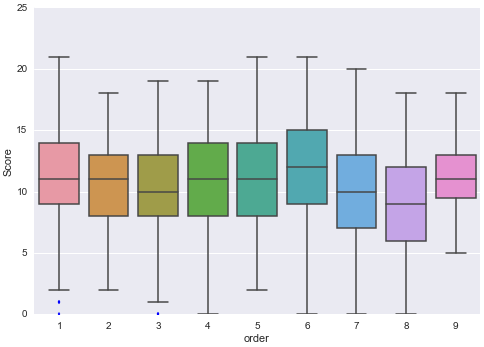

In [43]:
sns.boxplot(vals=scores.Score, groupby=scores.order)

## Number of tastings per person
Some of us have been to wine club more frequently (or longer) than others, so its useful to visualize the number of datapoints we have per person.

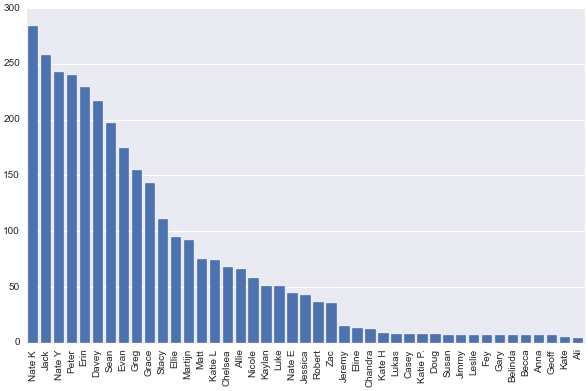

In [44]:
tastings = scores.groupby('Name').count().Score.copy()
tastings.sort()
plt.figure(figsize=(10,6))
ax = sns.barplot(x = np.arange(len(tastings)), y = tastings.values[::-1])
tl = ax.set_xticklabels(tastings.index[::-1], rotation=90)

## Average score per person
We don't want anyone to have a higher overall weight on a wines averaged score, so we'll next look on how well we each do on sticking to a consistent scoring basis. (Note, ratings from season 1 have already been re-normalized to 0-21). We're also not too interested in people who have only shown up once or twice ("Are you guys playing some sort of game?"), so we'll make the cuttoff at Zac and above (sorry Jeremy)

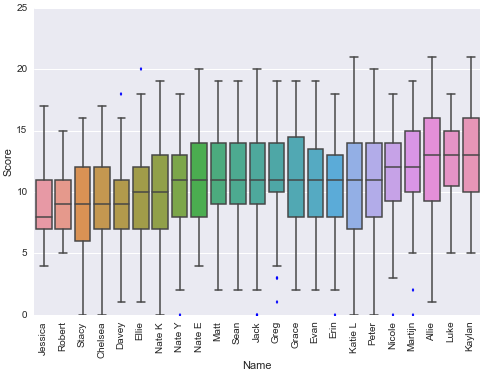

In [45]:
best_tasters = tastings[tastings > tastings['Zac']].index.values
pruned_scores = scores[scores.Name.isin(best_tasters)]
order = pruned_scores.groupby('Name').median().Score.argsort()
ax = sns.boxplot(vals=pruned_scores.Score, groupby=pruned_scores.Name, order=order.index[order.values])
tl = plt.setp(ax.get_xticklabels(), rotation=90)

Easy there Luke / Kaylan, we all like wine, but not _that_ much :)
I'm going to use a [robust z-score](http://www.ncbi.nlm.nih.gov/pmc/articles/PMC2789971/) to standardize our scores by taster.

In [46]:
def robust_z(x):
    x = x.drop(['Name'], axis=1)
    dev = x - x.median()
    mad = np.abs(dev).median()
    return dev / mad

scores['scaled_score'] = scores.loc[:,['Name', 'Score']].groupby('Name').apply(robust_z)

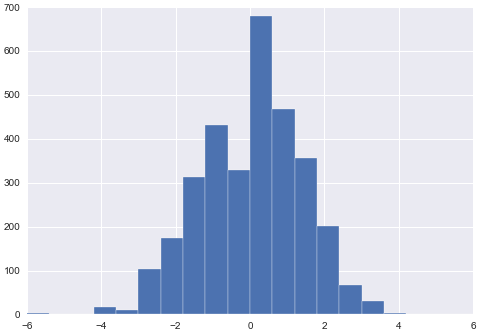

In [47]:
scores.scaled_score.hist(bins=20, range=(-6,6))

## Is there a pareto front of $f(taste, price)$?
This requires us to find the median score of each wine

In [48]:
medians = scores.groupby('wine').median().scaled_score
low = medians - scores.groupby('wine').quantile(0.25).scaled_score
high = scores.groupby('wine').quantile(0.75).scaled_score - medians

In [49]:
medians

wine
0      -2.000000
1      -0.666667
2      -1.000000
3      -0.333333
4       0.000000
5       0.600000
6      -1.000000
7      -0.333333
8       1.333333
9       0.333333
10      0.666667
11     -1.666667
12      0.666667
13      0.666667
14      1.333333
...
269     0.666667
270     0.000000
271    -1.333333
272     1.333333
273     0.666667
274     0.333333
275     0.333333
276     0.500000
277    -0.666667
278    -0.500000
279     0.000000
280    -0.333333
281     1.000000
282    -0.333333
283     0.000000
Name: scaled_score, Length: 284, dtype: float64

(-4, 4)

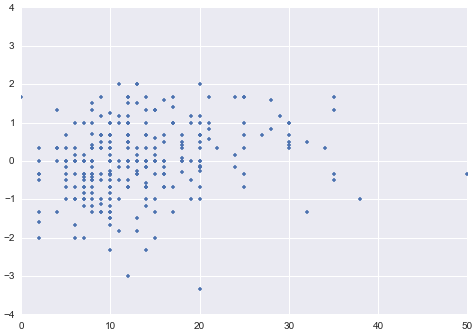

In [56]:
plt.plot(wines.Price, medians, '.')
plt.gca().set_ylim([-4, 4])

In [82]:
import statsmodels.api as sm
data = wines.loc[:,['Price', 'order']].copy()
data = sm.add_constant(data)
has_price = data.Price.notnull()
rlm_model = sm.RLM(medians[has_price], data[has_price])
results = rlm_model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:           scaled_score   No. Observations:                  278
Model:                            RLM   Df Residuals:                      275
Method:                          IRLS   Df Model:                            2
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Thu, 02 Apr 2015                                         
Time:                        17:48:44                                         
No. Iterations:                    16                                         
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         -0.3553      0.160     -2.225      0.026        -0.668    -0.042
Price          0.0317      0.008      4.159      0.000         0.017     0.047
order         -0.0050      0.026     -0.190      0.849        -0.056     0.046
==============================================================================

If the model instance has been used for another fit with different fit
parameters, then the fit options might not be the correct ones anymore .
"""